# Experimental Quantum Generative Adversarial Networks for Image Generation
A paper by Huang et al.

In [1]:
import jax.config
jax.config.update('jax_enable_x64', True)
import jax
import jax.numpy as jnp
import pennylane as qml
import quantumgan as gan
import matplotlib.pyplot as plt
import optax
from helpers import *

key = jax.random.PRNGKey(1234)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Batch GAN

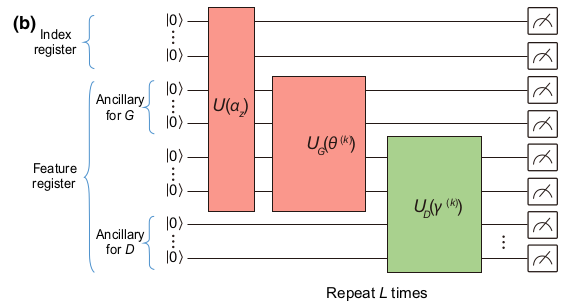

### Dataset

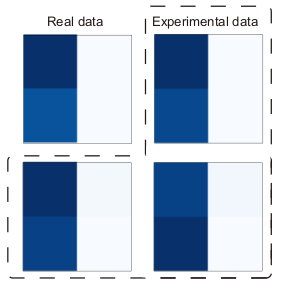

$$\mathbf{x}\in\mathbb{R}^{2\times 2}$$
$$\mathbf{x}_{00}\sim\text{unif}(0.4,0.6)$$
$$\mathbf{x}_{10}=1-\mathbf{x}_{0i}$$
$$\mathbf{x}_{01,11}=0$$

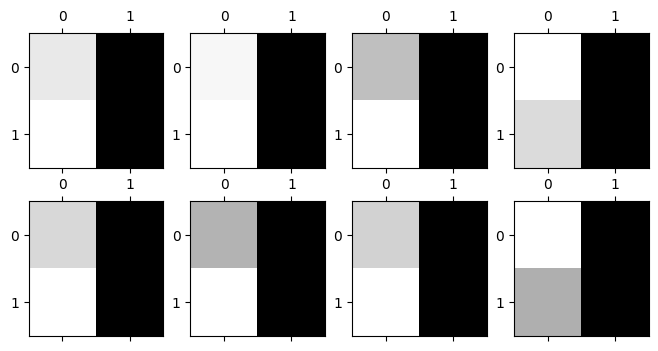

In [2]:
data_key, key = jax.random.split(key)
def generate_data(batch):
    global data_key
    k, data_key = jax.random.split(data_key)
    d = jnp.zeros((batch, 4))
    d_noise = jax.random.uniform(k, (batch,), jnp.float32, 0.4, 0.6)
    d = d.at[:,0].set(d_noise)
    d = d.at[:,2].set(1-d_noise)
    return d

_ = grid_imshow(2, 4, 2, 2, generate_data(8).reshape((2,4,2,2)))

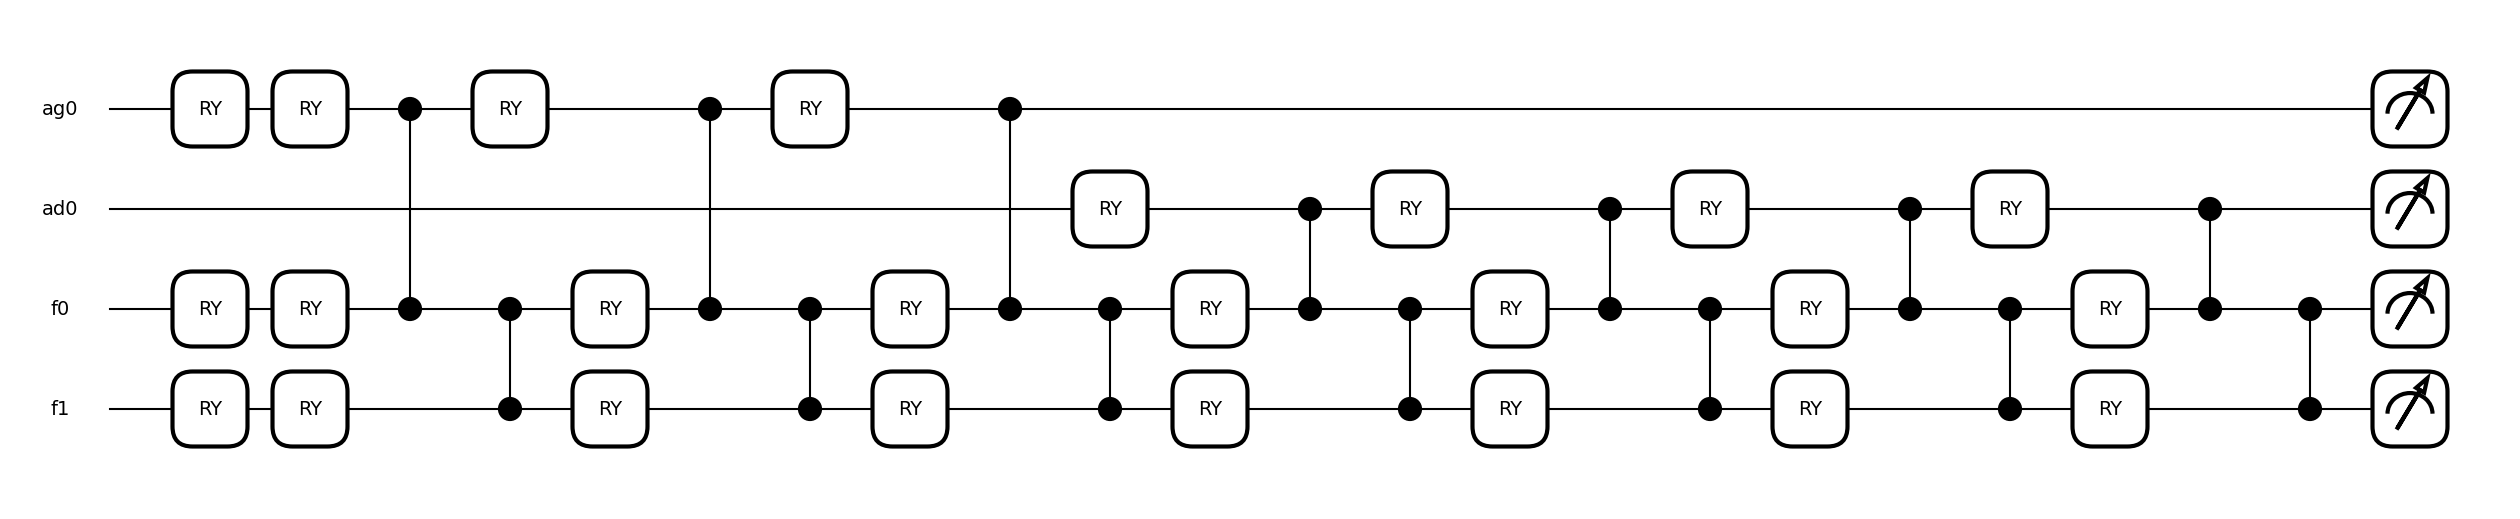

In [3]:
bar_gan = gan.BatchGAN(4, 1, 3, 1, 4) # 4, 2, 8, 2, 8
init_key, key = jax.random.split(key)
bar_gan.draw(*bar_gan.init_params(key))

In [4]:
gen_optimizer = optax.sgd(0.05)
dis_optimizer = optax.sgd(0.001)

def train(iters):
    global key
    gen_params, dis_params = bar_gan.init_params(key)

    gen_s = gen_optimizer.init(gen_params)
    dis_s = dis_optimizer.init(dis_params)
    
    @jax.jit
    def step(gen_params, dis_params, gen_s, dis_s, latent, example):
        g_loss, g_grad = jax.value_and_grad(bar_gan.gen_loss)(gen_params, dis_params, latent, example)
        d_loss, d_grad = jax.value_and_grad(bar_gan.dis_loss)(dis_params, gen_params, latent, example)
        g_updates, gen_s = gen_optimizer.update(g_grad, gen_s, gen_params)
        d_updates, dis_s = dis_optimizer.update(d_grad, dis_s, dis_params)
        gen_params = optax.apply_updates(gen_params, g_updates)
        dis_params = optax.apply_updates(dis_params, d_updates)
        return gen_params, dis_params, gen_s, dis_s, g_loss, d_loss
    
    for i in range(iters):
        example = generate_data(1)
        latent_key, key = jax.random.split(key)
        latent = bar_gan.gen_latent(latent_key, 1)
        gen_params, dis_params, gen_s, dis_s, g_loss, d_loss = step(
            gen_params, dis_params, gen_s, dis_s, latent, example
        )
        if i % 1000 == 0:
            print(f'{i:5}/{iters} gen: {g_loss:5.4f} dis: {d_loss:5.4f}')
    
    gen_params
    return gen_params, dis_params

In [5]:
gen_params, dis_params = train(10000)

    0/10000 gen: 1.1964 dis: 0.5380
 1000/10000 gen: 0.3831 dis: 0.7633
 2000/10000 gen: 0.6000 dis: 0.6830
 3000/10000 gen: 0.6569 dis: 0.6942
 4000/10000 gen: 0.6761 dis: 0.6992
 5000/10000 gen: 0.7042 dis: 0.6893
 6000/10000 gen: 0.6902 dis: 0.6957
 7000/10000 gen: 0.6970 dis: 0.6914
 8000/10000 gen: 0.6882 dis: 0.6945
 9000/10000 gen: 0.6907 dis: 0.6927


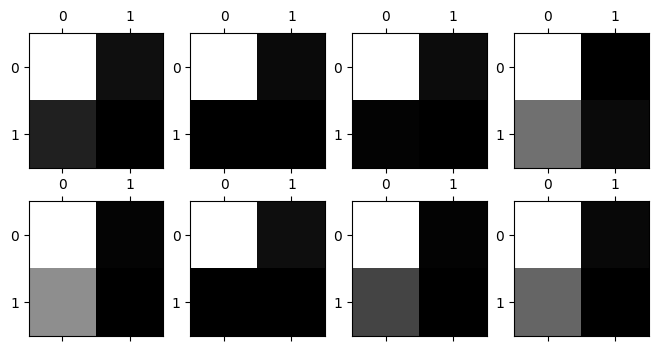

In [6]:
gen_key, key = jax.random.split(key)
d = bar_gan.generate(gen_params, gen_key, 8).reshape(2,4,2,2)
_ = grid_imshow(2, 4, 2, 2, d)